# Kaggle Readability prize playground

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import string
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pandas.io.json import json_normalize

import os

In [2]:
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

In [3]:
train_set = '../datasets/commonlitreadabilityprize/train.csv'
test_set = '../datasets/commonlitreadabilityprize/test.csv'
submit_sample = '../datasets/commonlitreadabilityprize/sample_submission.csv'

In [4]:
df = pd.read_csv(train_set)
df.columns

Index(['id', 'url_legal', 'license', 'excerpt', 'target', 'standard_error'], dtype='object')

## Columns
* id - unique ID for excerpt
* url_legal - URL of source - this is blank in the test set.
* license - license of source material - this is blank in the test set.
* excerpt - text to predict reading ease of
* target - reading ease
* standard_error - measure of spread of scores among multiple raters for each excerpt. Not included for test data.

In [5]:
df.head()

,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845


In [6]:
len(df)

2834

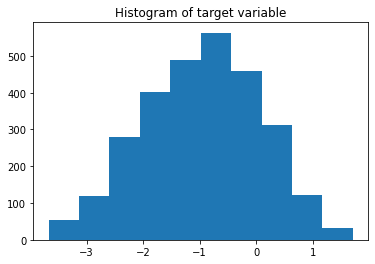

count    2834.000000
mean       -0.959319
std         1.033579
min        -3.676268
25%        -1.690320
50%        -0.912190
75%        -0.202540
max         1.711390
Name: target, dtype: float64


In [7]:
plt.hist(df.target, bins = 10)
plt.title("Histogram of target variable")
plt.show()
print(df.target.describe())

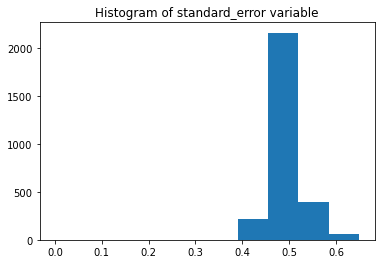

count    2834.000000
mean        0.491435
std         0.034818
min         0.000000
25%         0.468543
50%         0.484721
75%         0.506268
max         0.649671
Name: standard_error, dtype: float64


In [8]:
plt.hist(df.standard_error, bins = 10)
plt.title("Histogram of standard_error variable")
plt.show()
print(df.standard_error.describe())

## Cleaning
* Hay algunos NaN pero en columnas irrelevantes.
* Ojo, hay celdas 0.0 en una fila: por eso la distorsión en el min del std_err

In [9]:
df[df['target'] == 0.0]

,id,url_legal,license,excerpt,target,standard_error
106,436ce79fe,NaN,NaN,"The sun was shining in a cloudless sky, and no...",0.0,0.0


In [10]:
df = df.drop([106]) # why do we erase this line? is better to keep all the data. Zero seems to be a qualification.

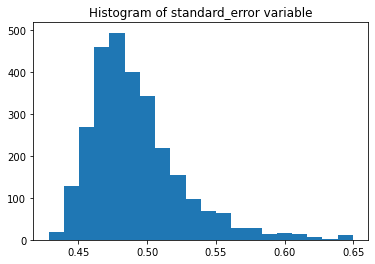

count    2833.000000
mean        0.491609
std         0.033577
min         0.428233
25%         0.468553
50%         0.484748
75%         0.506304
max         0.649671
Name: standard_error, dtype: float64


In [11]:
plt.hist(df.standard_error, bins = 20)
plt.title("Histogram of standard_error variable")
plt.show()
print(df.standard_error.describe())

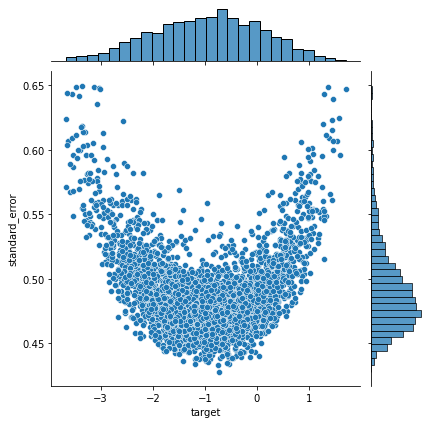

In [12]:
sns.jointplot(x='target', y='standard_error', data=df)

## De acuerdo
* Veamos los textos donde los raters estuvieron de acuerdo (bajo spread) sobre su facilidad de lectura:
* Ordenado por mayor target (y observemos el standard error).


## Los mejores textos:

In [13]:
mejores = df[['id','excerpt', 'target', 'standard_error']].sort_values('target', ascending = False)[:20]

In [14]:
mejores.head()

,id,excerpt,target,standard_error
2829,25ca8f498,When you think of dinosaurs and where they liv...,1.711390,0.646900
981,849971671,"For her last birthday, Sisanda had a special t...",1.597870,0.596349
808,8f35441e3,"Every day, Emeka's father took him to school i...",1.583847,0.624776
1014,7a1d484be,More people came to the bus stop just before 9...,1.541672,0.606997
1066,016913371,Grandma's garden was wonderful. It was full of...,1.467665,0.599600


## Los peores textos:

In [15]:
peores = df[['id','excerpt', 'target', 'standard_error']].sort_values('target', ascending = True)[:20]
peores.head()

,id,excerpt,target,standard_error
1705,4626100d8,"The commutator is peculiar, consisting of only...",-3.676268,0.623621
1128,493b80aa7,The Dunwich horror itself came between Lammas ...,-3.668360,0.571404
1754,fe44cbd14,"The iron cylinder weighs 23 kilogrammes; but, ...",-3.642892,0.644398
1752,284eaa5ad,As to surface-slope its measurement—from nearl...,-3.639936,0.603819
1720,9e9eacb49,"The tree is dioecious, bearing male catkins on...",-3.636834,0.606822


## Observaciones
* 1. 
* 2. 

# Feature Engineering: Generating some basic features

In [16]:
# Here we are taking the NLP statistics by hand...did you mention we have a library for this?
df['word_count'] = df['excerpt'].apply(lambda x: len(str(x).split()))
df['char_count'] = df['excerpt'].apply(lambda x: len(str(x)))
df['avg_word_length'] = df['char_count'] / df['word_count']

df['unique_words_count'] = df['excerpt'].apply(lambda x: len(set( x.split(' ') ))) # Neat usage of the Set! :D
df['diversity'] = df['unique_words_count'] / df['word_count']

df.head()

,id,url_legal,license,excerpt,target,standard_error,word_count,char_count,avg_word_length,unique_words_count,diversity
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009,179,992,5.541899,112,0.625698
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805,169,937,5.544379,123,0.727811
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676,166,908,5.469880,124,0.746988
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007,164,909,5.542683,117,0.713415
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845,147,723,4.918367,51,0.346939


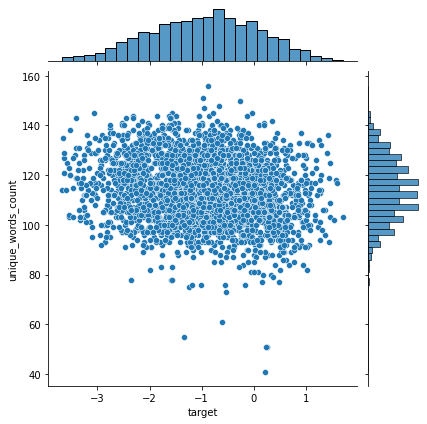

In [17]:
sns.jointplot(x='target', y='unique_words_count', data=df) # I do not understand what are you looking for with this chart...

# Data wrangling


In [18]:
df_clean = df.drop(columns=['license','url_legal'])

In [19]:
df_clean.describe() #Everyonhe seems to have more or less the same diversity; this is due to the fact that we didn't clean up the text from the articles and other connectors.

,target,standard_error,word_count,char_count,avg_word_length,unique_words_count,diversity
count,2833.000000,2833.000000,2833.000000,2833.000000,2833.000000,2833.000000,2833.000000
mean,-0.959657,0.491609,172.992940,971.804095,5.619931,113.901518,0.659472
std,1.033604,0.033577,16.967398,117.216975,0.429843,12.818148,0.051414
min,-3.676268,0.428233,135.000000,669.000000,4.252632,41.000000,0.235632
25%,-1.691501,0.468553,159.000000,885.000000,5.310811,105.000000,0.630682
50%,-0.913322,0.484748,175.000000,971.000000,5.573333,114.000000,0.663366
75%,-0.203079,0.506304,188.000000,1058.000000,5.872611,123.000000,0.693182
max,1.711390,0.649671,205.000000,1341.000000,8.083871,156.000000,0.800000


**Conclusion:** We got 205 possible columns to play with.

Some interesting libs to research:

* https://www.nltk.org/
* https://polyglot.readthedocs.io/en/latest/index.html

In [20]:
# Let's create a new dataframe with a column by word.
words_array = df_clean['excerpt'].str.split(' ',expand=True)

In [21]:
words_array.shape

(2833, 205)

In [22]:
words_array.describe()

,0,1,2,3,4,5,6,7,8,9,...,195,196,197,198,199,200,201,202,203,204
count,2833,2833,2833,2833,2833,2833,2833,2833,2833,2833,...,204,168,107,64,32,12,8,4,2,2
unique,820,1345,1253,1239,1285,1363,1376,1364,1353,1367,...,162,143,95,58,32,12,7,4,2,2
top,The,the,a,the,the,the,the,the,the,the,...,the,the,to,the,alone.,memories.,and,their,alarm,water.
freq,485,172,154,158,224,193,176,185,188,163,...,13,11,7,5,1,1,2,1,1,1


In [23]:
words_array.head()

,0,1,2,3,4,5,6,7,8,9,...,195,196,197,198,199,200,201,202,203,204
0,When,the,young,people,returned,to,the,"ballroom,",it,presented,...,None,None,None,None,None,None,None,None,None,None
1,All,through,dinner,"time,",Mrs.,Fayre,was,somewhat,"silent,",her,...,None,None,None,None,None,None,None,None,None,None
2,As,Roger,had,"predicted,",the,snow,departed,as,quickly,as,...,None,None,None,None,None,None,None,None,None,None
3,And,outside,before,the,palace,a,great,garden,was,walled,...,None,None,None,None,None,None,None,None,None,None
4,Once,upon,a,time,there,were,Three,Bears,who,lived,...,None,None,None,None,None,None,None,None,None,None


## convert words to numbers

In [69]:
# genera un diccionario que usara la funcion convertir
conversor = {}
primos = [ 2 , 2,  3,  5,  7,  11, 11, 13, 17, 19, 23, 23, 29, 31, 37, 41, 43, 47, 53, 53, 59, 61, 67, 71, 73, 79, 79, 79, 83, 89, 97, 101, 103, 107, 109, 113, 127, 131, 137, 139, 149, 151, 157, 163, 167, 173, 179, 181, 191, 193, 197, 199, 211, 223, 227, 229, 233, 239, 241, 251, 257, 263, 269, 271]
letras = ['a','á','b','c','d','e','é','f','g','h','i','í','j','k','l','m','n','ñ','o','ó','p','q','r','s','t','u','ú','ü','v','w','x','y','z']
i = 0
for l in letras:
    conversor[l] = primos [i]
    i = i + 1

In [155]:
def convertir (palabra):
    ret = 1
    if palabra is None :
        return 0
    if len(palabra) == 0: # si es una string nula (o celda vacia) retorno 0.
        return 0
    # si hay signos de puntuacion o blancos los borro.
    # string.punctuation -> '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
    palabra = palabra.strip() # borro blancos al principio o final de la palabra.
    palabra = palabra.translate(str.maketrans('', '', string.punctuation))
    try: # si la palabra esta formada solo por numeros (1 o mas chars).
        number = int(palabra)
        return 0
    except:
        number = 0
    palabra = palabra.lower()
    letters = list(palabra)
    for lt in letters:
        if lt == ' ' : # si por algun motivo hay blancos en medio de la palabra.
            return 0
        try: # si la palabra contiene numeros la ignoro y retorno 0.
            number = int(lt)
            return 0
        except:
            number = 0
        try: # intento buscar en el diccionario de conversion
            if (lt==letters[0]) :
                ret = ret + conversor[lt] +1
            else :
                ret = ret + conversor[lt]       
        except:
            ret = 0
    return ret

In [156]:
PrimeWords = pd.DataFrame()

In [29]:
df_final = pd.concat([df_clean, words_array], axis=1)

In [98]:
df_final.head()

,id,excerpt,target,standard_error,word_count,char_count,avg_word_length,unique_words_count,diversity,0,...,195,196,197,198,199,200,201,202,203,204
0,c12129c31,When the young people returned to the ballroom...,-0.340259,0.464009,179,992,5.541899,112,0.625698,When,...,None,None,None,None,None,None,None,None,None,None
1,85aa80a4c,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805,169,937,5.544379,123,0.727811,All,...,None,None,None,None,None,None,None,None,None,None
2,b69ac6792,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676,166,908,5.469880,124,0.746988,As,...,None,None,None,None,None,None,None,None,None,None
3,dd1000b26,And outside before the palace a great garden w...,-1.054013,0.450007,164,909,5.542683,117,0.713415,And,...,None,None,None,None,None,None,None,None,None,None
4,37c1b32fb,Once upon a time there were Three Bears who li...,0.247197,0.510845,147,723,4.918367,51,0.346939,Once,...,None,None,None,None,None,None,None,None,None,None


In [116]:
df_final_clean = df_final.drop(columns=['excerpt', 'id'])

In [117]:
df_final_clean.head()

,target,standard_error,word_count,char_count,avg_word_length,unique_words_count,diversity,0,1,2,...,195,196,197,198,199,200,201,202,203,204
0,-0.340259,0.464009,179,992,5.541899,112,0.625698,When,the,young,...,None,None,None,None,None,None,None,None,None,None
1,-0.315372,0.480805,169,937,5.544379,123,0.727811,All,through,dinner,...,None,None,None,None,None,None,None,None,None,None
2,-0.580118,0.476676,166,908,5.469880,124,0.746988,As,Roger,had,...,None,None,None,None,None,None,None,None,None,None
3,-1.054013,0.450007,164,909,5.542683,117,0.713415,And,outside,before,...,None,None,None,None,None,None,None,None,None,None
4,0.247197,0.510845,147,723,4.918367,51,0.346939,Once,upon,a,...,None,None,None,None,None,None,None,None,None,None


## Let's try training a simple neural network for prediction

In [118]:
df_final_clean2 = df_final_clean.drop(columns=['target', 'standard_error', 'word_count', 'char_count', 'avg_word_length', 'unique_words_count', 'diversity'])

In [119]:
df_final_clean2

,0,1,2,3,4,5,6,7,8,9,...,195,196,197,198,199,200,201,202,203,204
0,When,the,young,people,returned,to,the,"ballroom,",it,presented,...,None,None,None,None,None,None,None,None,None,None
1,All,through,dinner,"time,",Mrs.,Fayre,was,somewhat,"silent,",her,...,None,None,None,None,None,None,None,None,None,None
2,As,Roger,had,"predicted,",the,snow,departed,as,quickly,as,...,None,None,None,None,None,None,None,None,None,None
3,And,outside,before,the,palace,a,great,garden,was,walled,...,None,None,None,None,None,None,None,None,None,None
4,Once,upon,a,time,there,were,Three,Bears,who,lived,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2829,When,you,think,of,dinosaurs,and,where,they,"lived,",what,...,None,None,None,None,None,None,None,None,None,None
2830,So,what,is,a,solid?,Solids,are,usually,hard,because,...,None,None,None,None,None,None,None,None,None,None
2831,The,second,state,of,matter,we,will,discuss,is,a,...,None,None,None,None,None,None,None,None,None,None
2832,Solids,are,shapes,that,you,can,actually,touch.,They,have,...,None,None,None,None,None,None,None,None,None,None


In [ ]:
import functools 

In [157]:
PrimeWords = df_final_clean2.applymap(lambda x: convertir(x))

In [158]:
PrimeWords.head()

,0,1,2,3,4,5,6,7,8,9,...,195,196,197,198,199,200,201,202,203,204
0,164,105,295,233,361,128,105,295,98,355,...,0,0,0,0,0,0,0,0,0,0
1,78,329,196,150,181,196,164,361,260,99,...,0,0,0,0,0,0,0,0,0,0
2,75,218,30,265,105,258,240,75,339,75,...,0,0,0,0,0,0,0,0,0,0
3,54,319,160,105,118,4,172,149,164,185,...,0,0,0,0,0,0,0,0,0,0
4,114,236,4,150,183,180,183,156,163,163,...,0,0,0,0,0,0,0,0,0,0


In [159]:
df_clean

,id,excerpt,target,standard_error,word_count,char_count,avg_word_length,unique_words_count,diversity
0,c12129c31,When the young people returned to the ballroom...,-0.340259,0.464009,179,992,5.541899,112,0.625698
1,85aa80a4c,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805,169,937,5.544379,123,0.727811
2,b69ac6792,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676,166,908,5.469880,124,0.746988
3,dd1000b26,And outside before the palace a great garden w...,-1.054013,0.450007,164,909,5.542683,117,0.713415
4,37c1b32fb,Once upon a time there were Three Bears who li...,0.247197,0.510845,147,723,4.918367,51,0.346939
...,...,...,...,...,...,...,...,...,...
2829,25ca8f498,When you think of dinosaurs and where they liv...,1.711390,0.646900,145,901,6.213793,103,0.710345
2830,2c26db523,So what is a solid? Solids are usually hard be...,0.189476,0.535648,164,890,5.426829,105,0.640244
2831,cd19e2350,The second state of matter we will discuss is ...,0.255209,0.483866,190,949,4.994737,99,0.521053
2832,15e2e9e7a,Solids are shapes that you can actually touch....,-0.215279,0.514128,150,864,5.760000,102,0.680000


In [160]:
df_final = pd.concat([df_clean, PrimeWords], axis=1)

In [161]:
df_final_clean = df_final.drop(columns=['excerpt', 'id'])

In [162]:
df_final_clean

,target,standard_error,word_count,char_count,avg_word_length,unique_words_count,diversity,0,1,2,...,195,196,197,198,199,200,201,202,203,204
0,-0.340259,0.464009,179,992,5.541899,112,0.625698,164,105,295,...,0,0,0,0,0,0,0,0,0,0
1,-0.315372,0.480805,169,937,5.544379,123,0.727811,78,329,196,...,0,0,0,0,0,0,0,0,0,0
2,-0.580118,0.476676,166,908,5.469880,124,0.746988,75,218,30,...,0,0,0,0,0,0,0,0,0,0
3,-1.054013,0.450007,164,909,5.542683,117,0.713415,54,319,160,...,0,0,0,0,0,0,0,0,0,0
4,0.247197,0.510845,147,723,4.918367,51,0.346939,114,236,4,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2829,1.711390,0.646900,145,901,6.213793,103,0.710345,164,235,191,...,0,0,0,0,0,0,0,0,0,0
2830,0.189476,0.535648,164,890,5.426829,105,0.640244,126,185,96,...,0,0,0,0,0,0,0,0,0,0
2831,0.255209,0.483866,190,949,4.994737,99,0.521053,105,192,232,...,0,0,0,0,0,0,0,0,0,0
2832,-0.215279,0.514128,150,864,5.760000,102,0.680000,265,82,236,...,0,0,0,0,0,0,0,0,0,0


In [163]:
# Preparing the data...
X = df_final_clean.drop(columns=['target', 'standard_error']).to_numpy()
y = df_final_clean['target'].to_numpy()

In [164]:
X.shape

(2833, 210)

In [165]:
y.shape

(2833,)

In [166]:
# The simplest of the simplest: a perceptron - we do this to stablish a base line - https://scikit-learn.org/stable/modules/neural_networks_supervised.html
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

# Split the data...
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# Defining the model & Training.
regr = MLPRegressor(random_state=1, max_iter=500).fit(X_train, y_train) # This is absolutely arbitrary, we are just looking...


In [167]:
y_test

array([-1.15975286e-01, -1.11521147e+00, -1.04064704e+00, -1.78598436e+00,
       -1.23442650e+00, -1.32555035e+00, -2.37602132e+00,  1.44438495e+00,
       -1.57742987e+00, -2.70928562e+00,  1.92178063e-01, -1.01555009e-01,
       -8.85427000e-02, -1.43656378e+00, -9.59590900e-01, -2.67158712e-01,
       -1.27464643e+00, -8.94009394e-01,  5.66702680e-01, -4.63427538e-01,
        8.10292420e-02,  2.17075160e-01, -6.11789473e-01, -6.10296731e-01,
        1.43650344e+00, -4.27376752e-01, -2.51514391e+00, -1.73885503e+00,
       -2.08506012e+00, -5.63758857e-01, -1.31462877e+00, -1.64296950e+00,
       -1.89106197e+00, -1.80404877e+00, -1.16803301e+00,  2.92923680e-01,
       -1.41526348e+00, -1.32455133e+00, -1.71646610e+00, -2.40062482e+00,
        1.39892877e-01, -2.06076577e+00, -3.15739242e-01, -1.22770289e-01,
       -1.89544351e+00,  8.39942050e-02, -1.93335830e+00, -2.37818594e+00,
       -7.26209978e-01, -1.70876601e+00, -2.05012317e+00, -2.43327699e+00,
       -4.62051139e-01, -

In [168]:
# Let's try to predict: (we need first to prepare all the test set)
y_predict = regr.predict(X_test)

In [169]:
y_predict

array([-1.18652080e+00,  1.63994827e+00,  4.14312787e+00,  7.55604477e-02,
       -1.49575195e+00,  2.95039955e+00, -4.22539506e-01, -5.94871203e-01,
        4.84354905e-01,  1.67834708e-01, -1.07648577e+00,  1.37256309e+00,
       -6.25349829e-01,  2.29179436e+00, -1.24537306e+00, -1.57569948e+00,
        1.60342698e-01,  9.22941529e-01, -2.43541218e-01,  5.07104513e-01,
        1.37846889e+00,  3.89778880e-01,  4.87718429e-02, -7.78424915e-02,
        1.25926212e+00, -1.67835624e+00, -1.64905377e-01,  8.04106441e-01,
        1.53301181e+00, -5.36639153e-01, -5.57770631e-01,  6.71493309e-01,
        4.22494224e-01, -9.77652836e+00, -3.59940948e-01, -1.43454260e+00,
        3.34477153e-02,  1.08007775e+00,  1.17735488e+00, -2.48660605e+00,
       -1.37109136e+00,  2.29534563e+00,  2.89612092e+00, -1.29313103e-01,
        7.72887341e-01, -8.05632427e-01,  2.41950647e-01,  1.05850053e+00,
       -1.17981311e+00,  5.06211585e-01, -6.67603414e-02,  4.64494562e-01,
        5.25957133e-01,  

In [171]:
print(regr.score(X_test, y_test))

-11.405929834080546


In [ ]:
# Function to replace words by numbers
def prime_words_to_numbers(word):
    letter = word.

In [ ]:
# TODO: 
# 1)build up the PROPOSED test set with the proper format, 
# 2) construct a SME metric as well to gain further comparison with other algorithms.